In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

## Trust Region Strategy
A program that implements the dogleg method to solve the Rosenbrock’s function. Choosing $B_k$ to be the exact
Hessian.

In [2]:
#Reference
# https://github.com/funnydman/BFGS-NelderMead-TrustRegion/blob/master/trust_region_dogleg.py

import scipy as sp

def rosen(x):
    f = (1-x[0])**2 + 100*(x[1] - x[0]**2)**2
    return f

def rosen_der(x):
    fx = -2 + 2*x[0] + 400*x[0]**3 - 400*x[0]*x[1]
    fy = 200*(x[1] - x[0]**2)
    return np.array([fx,fy])

def rosen_hess(x):
    fxx = 2 + 1200*x[0]**2 -400*x[1]
    fxy = -400*x[0]
    fyx = -400*x[0]
    fyy = 200
    return np.array([[fxx,fxy], [fyx, fyy]])


def dogleg(H, g, B, trust_radius):
    pb = -H@g # full newton step
    norm_pb = np.linalg.norm(pb)
    
    # full newton step lies inside the trust region
    if np.linalg.norm(pb) <= trust_radius:
        return pb
    # step along the steepest descent direction
    pu = - (np.dot(g, g) / np.dot(g, B@g)) * g
    dot_pu = np.dot(pu, pu)
    norm_pu = np.sqrt(dot_pu)
    if norm_pu >= trust_radius:
        return trust_radius * pu / norm_pu
    
    # solve ||pu**2 +(tau-1)*(pb-pu)**2|| = trusr_radius**2
    pb_pu = pb - pu
    pb_pu_sq = np.dot(pb_pu, pb_pu)
    pu_pb_pu_sq = np.dot(pu, pb_pu)
    d = pu_pb_pu_sq ** 2 - pb_pu_sq * (dot_pu - trust_radius ** 2)
    tau = (-pu_pb_pu_sq + np.sqrt(d)) / pb_pu_sq+1

    # 0<tau<1
    if tau < 1:
        return pu*tau
    #1<tau<2
    return pu + (tau-1) * pb_pu


def trust_region(x0,eta=0.15,tol=1e-4,max_trust_radius=100.0):
    xx = []
    #initial point
    x = x0
    r = []
    #initial radius
    trust_radius = 1
    r.append(trust_radius)
    xx.append(x)
    while True :
        g = rosen_der(x) # gradient
        B = rosen_hess(x) #hessian
        H = np.linalg.inv(B)
        p = dogleg(H, g, B, trust_radius)
        rho = (rosen(x) - rosen(x + p))/(-(np.dot(g, p) + 0.5 * np.dot(p, B@p)))
        norm_p = np.linalg.norm(p)
        if rho < 0.25:
            trust_radius = 0.25 * norm_p
        else:
            if rho > 0.75 and norm_p == trust_radius:
                trust_radius = min(2.0 * trust_radius, max_trust_radius)
            else:
                trust_radius = trust_radius
        r.append(trust_radius)
        if rho > eta:
            x = x + p
        xx.append(x)
        if np.linalg.norm(g) < tol:
            break
    return np.asarray(xx),r
def visualize(xx,r):
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    Z = (1-X)**2 + 100*(Y-X**2)**2
    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(20)
    cp = ax.contour(x,y,Z, np.arange(2,10)**4)
    ax.plot(xx[:,0],xx[:,1], '-o', color='black', markersize=4)
    color = ['red','blue','green','yellow']
    for i in range(len(r)):
        circle1 = plt.Circle(xx[i], radius=r[i],facecolor = color[i%len(color)],alpha = 0.2)
        ax.add_artist(circle1)
    ax.clabel(cp, inline=True, fontsize=10)
    ax.set_title('Plot showing trust region', fontsize = 18,fontweight='bold')
    ax.set_xlabel('X',fontsize=16,fontweight='bold')
    ax.set_ylabel('Y',fontsize=16,fontweight='bold')
    ax.annotate('point of minima [1,1]',
            xy=(1, 1.1), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom',fontsize = 18)

    plt.show()
def fun(initial_point,eta): 
    xx,r = trust_region(initial_point , eta)
    print('Number of steps taken to converge = ',len(r))
    visualize(xx,r)

Number of steps taken to converge =  19


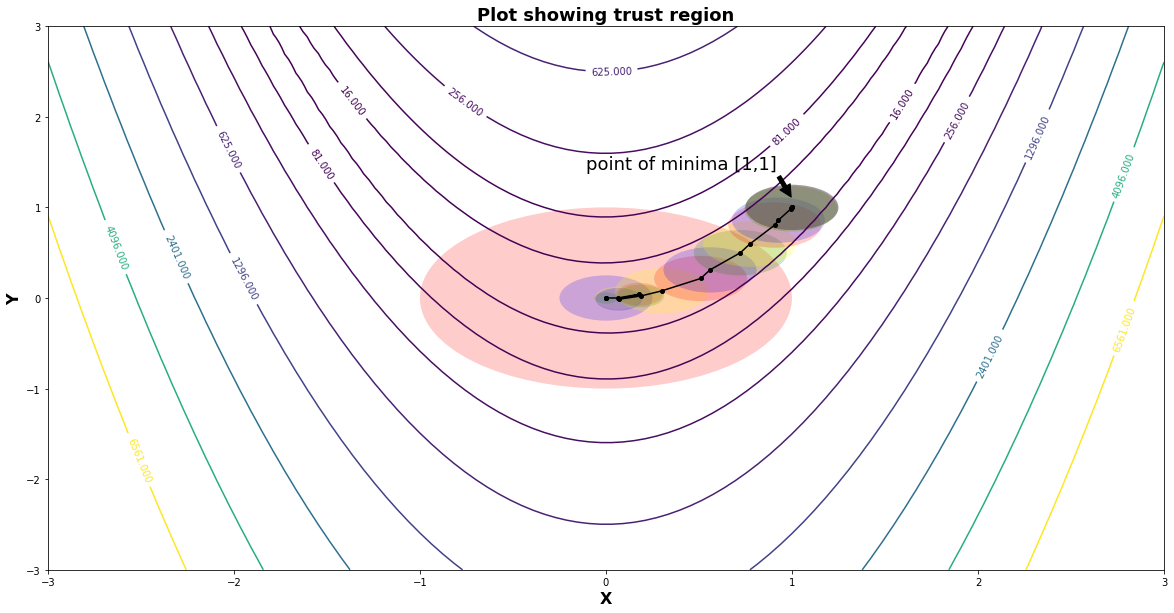

In [3]:
##initial point at [0,0]
## trust region for a point is shown by the light colour circle drawn around a point with specific trust radius
fun([0,0],0.15)

Number of steps taken to converge =  33


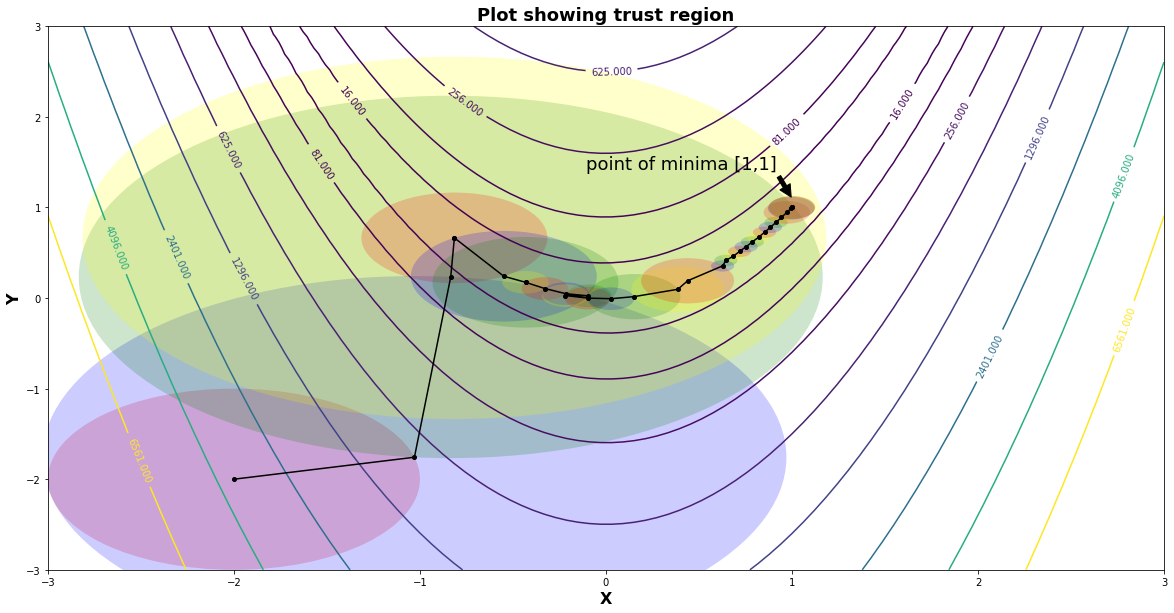

In [4]:
##initial point at [0,0]
## trust region for a point is shown by the light colour circle drawn around a point with specific trust radius
fun([-2,-2],0.15)

The trust region radius keeps on changing according to the value of rho. As we approach convergence, the trust region radius becomes smaller. The farther the initial point, the number of steps taken for convergence increases.

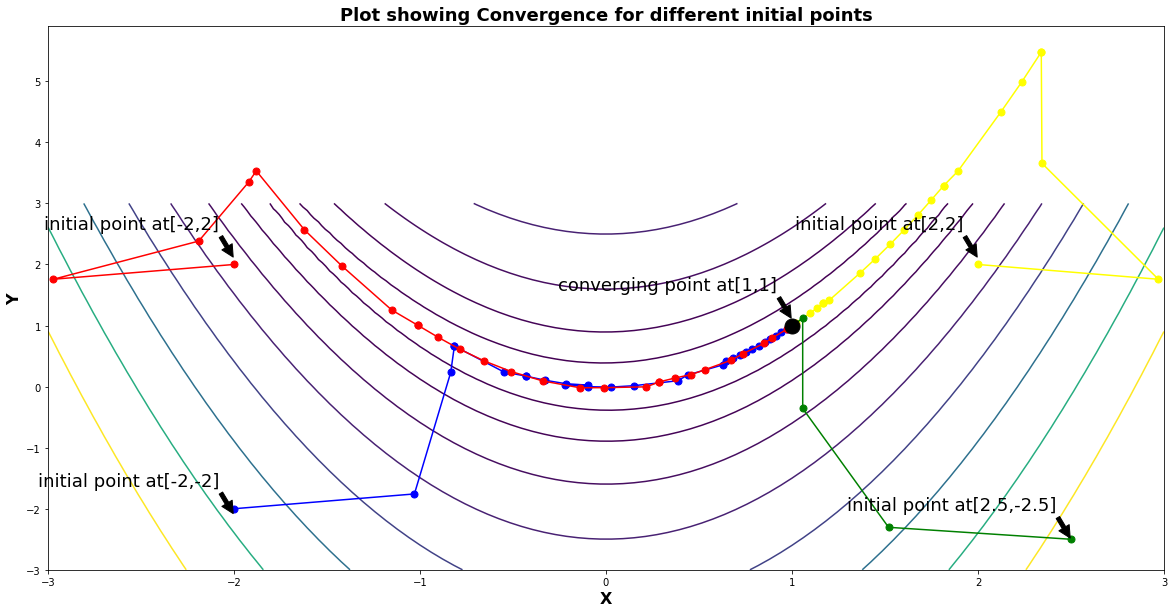

In [5]:
xx1,_ = trust_region([2,2] , 0.15)
xx2,_ = trust_region([-2,-2] , 0.15)
xx3,_ = trust_region([-2,2] , 0.15)
xx4,_ = trust_region([2.5,-2.5] , 0.15)

x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = (1-X)**2 + 100*(Y-X**2)**2
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
cp = ax.contour(X,Y,Z, np.arange(2,10)**4)
ax.plot(xx1[:,0],xx1[:,1], '-o', color='yellow', markersize=7)
ax.plot(xx2[:,0],xx2[:,1], '-o', color='blue', markersize=7)
ax.plot(xx3[:,0],xx3[:,1], '-o', color='red', markersize=7)
ax.plot(xx4[:,0],xx4[:,1], '-o', color='green', markersize=7)
ax.plot(xx1[-1,0],xx1[-1,1], '-o', color='black', markersize=15)
ax.annotate('converging point at[1,1]',
            xy=(1, 1.1), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom',fontsize = 18)

ax.annotate('initial point at[-2,-2]',
            xy=(-2, -2.1), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom',fontsize = 18)
ax.annotate('initial point at[2,2]',
            xy=(2, 2.1), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom',fontsize = 18)
ax.annotate('initial point at[-2,2]',
            xy=(-2, 2.1), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom',fontsize = 18)
ax.annotate('initial point at[2.5,-2.5]',
            xy=(2.5, -2.5), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom',fontsize = 18)
ax.set_title('Plot showing Convergence for different initial points', fontsize = 18,fontweight='bold')
ax.set_xlabel('X',fontsize=16,fontweight='bold')
ax.set_ylabel('Y',fontsize=16,fontweight='bold')
plt.show()


Irrespective of different initial points, the method converges at minima.

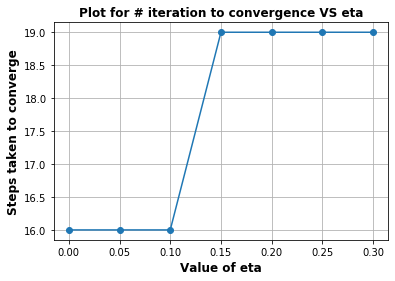

In [6]:
#varying the value of eta(from 0 to 0.35) steps taken to converge
steps = []
steps.append(len(trust_region([0,0],0.0)[0]))
steps.append(len(trust_region([0,0],0.05)[0]))
steps.append(len(trust_region([0,0],0.1)[0]))
steps.append(len(trust_region([0,0],0.15)[0]))
steps.append(len(trust_region([0,0],0.2)[0]))
steps.append(len(trust_region([0,0],0.25)[0]))
steps.append(len(trust_region([0,0],0.3)[0]))
x = [0,0.05,0.1,0.15,0.2,0.25,0.3]
plt.plot(x,steps,"-o")
plt.title("Plot for # iteration to convergence VS eta",fontweight='bold')
plt.xlabel('Value of eta',fontsize=12,fontweight='bold')
plt.ylabel('Steps taken to converge',fontsize=12,fontweight='bold')
plt.grid()

With increase in the value of eta (threshold) , number of steps taken also increases. For values greater than 0.35 the method does not converge.

### Family of solutions of the quadratic sub-problem as the trust region radius varies:
Given $f(x) = 20(x_2−x^2_1)^2+ (1−x_1)^2$. <br>
The quadratic model is $m(p) =f+\nabla f^Tp+\frac{1}{2}p^TBp$<br>
where $B$ is Hessian matrix of $f$.

For given function $f$,
$$
\nabla f = \begin{bmatrix}−80x_1(x_2−x^2_1)−2(1−x_1) \\ 40(x_2−x^2_1) \end{bmatrix} \text{ and } 
B = \nabla^2 f = \begin{bmatrix}−80x_2+ 240x^2_1+ 2 && −80x_1 \\ −80x_1 && 40 \end{bmatrix}
$$


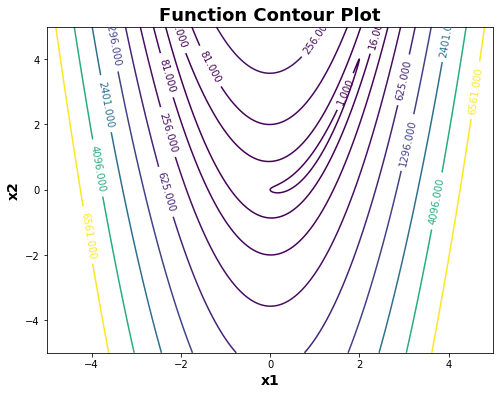

In [7]:
x = np.linspace(-5, 5, 1000)
y = np.linspace(-5, 5, 1000)
X, Y = np.meshgrid(x, y)
Z = (1-X)**2 + 20*(Y-X**2)**2

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(8)
cp = ax.contour(x,y,Z, np.arange(10)**4)
ax.clabel(cp, inline=True, fontsize=10)
ax.set_title('Function Contour Plot', fontsize = 18,fontweight='bold')
ax.set_xlabel('x1',fontsize = 14,fontweight='bold')
ax.set_ylabel('x2',fontsize = 14,fontweight='bold')
plt.show()

In [8]:
#Fuction similar like Rosenbrock
def rosenb_f(x):
    f = (1-x[0])**2 + 20*(x[1] - x[0]**2)**2
    return f

def grad_rosenb(x):
    fx = -2 + 2*x[0] + 80*x[0]**3 - 80*x[0]*x[1]
    fy = 40*(x[1] - x[0]**2)
    return np.array([fx,fy])

def hessian_rosenb(x):
    fxx = 2 + 240*x[0]**2 -80*x[1]
    fxy = -80*x[0]
    fyx = -80*x[0]
    fyy = 40
    return np.array([[fxx,fxy], [fyx, fyy]])

def quad_model(p,x):
    m = rosenb_f(x) + np.dot(p.T,grad_rosenb(x)) + 0.5*p.T@hessian_rosenb(x)@p
    return m

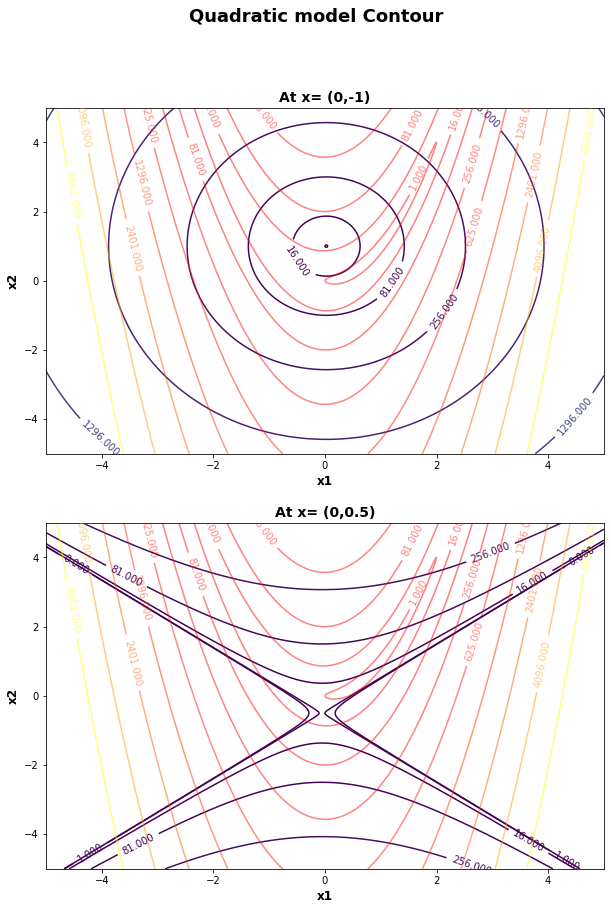

In [9]:
import matplotlib.cm as cm
x = np.linspace(-5, 5, 1000)
y = np.linspace(-5, 5, 1000)
X, Y = np.meshgrid(x, y)

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figheight(14)
fig.set_figwidth(10)
fig.suptitle('Quadratic model Contour', fontsize = 18,fontweight="bold")

Z = 41*(X**2)+20*(Y**2) -2*X-40*Y+21
cp = ax1.contour(x,y,Z, np.arange(10)**4)
ax1.clabel(cp, inline=True, 
          fontsize=10)
Z = (1-X)**2 + 20*(Y-X**2)**2
cp = ax1.contour(x,y,Z, np.arange(10)**4,cmap=cm.autumn,alpha=0.5)
ax1.clabel(cp, inline=True, 
          fontsize=10)
ax1.set_title('At x= '+str('(0,-1)'), fontsize = 14,fontweight="bold")
ax1.set_xlabel('x1',fontsize=12,fontweight="bold")
ax1.set_ylabel('x2',fontsize=12,fontweight="bold")


Z = -19*(X**2)+20*(Y**2) -2*X+20*Y+6
cp = ax2.contour(x,y,Z, np.arange(10)**4,)
ax2.clabel(cp, inline=True, 
          fontsize=10)
Z = (1-X)**2 + 20*(Y-X**2)**2
cp = ax2.contour(x,y,Z, np.arange(10)**4,cmap = cm.autumn,alpha=0.5)
ax2.clabel(cp, inline=True, 
          fontsize=10)
ax2.set_title('At x= '+str('(0,0.5)'), fontsize = 14,fontweight="bold")
ax2.set_xlabel('x1',fontsize=12,fontweight="bold")
ax2.set_ylabel('x2',fontsize=12,fontweight="bold")
plt.show()

### Note
The highlighted contour lines are of quadratic model and the lighter ones are those of the function.

In [10]:
x = np.array([0,-1])
print('Function, gradient and hessian values for x= ',x)
print(rosenb_f(x),'\n',grad_rosenb(x),'\n',hessian_rosenb(x))
x = np.array([0,0.5])
print('Function, gradient and hessian values for x= ',x)
print(rosenb_f(x),'\n',grad_rosenb(x),'\n',hessian_rosenb(x))

Function, gradient and hessian values for x=  [ 0 -1]
21 
 [ -2 -40] 
 [[82  0]
 [ 0 40]]
Function, gradient and hessian values for x=  [0.  0.5]
6.0 
 [-2. 20.] 
 [[-38.  -0.]
 [ -0.  40.]]



$p^*$ is said to be solution of following quadratic subproblem
$$
\min_{p} m(p) =f+\nabla f^Tp+\frac{1}{2}p^TBp \space \space \space\text{s.t.}\space \space\lVert p\rVert \leq ∆ \space;
$$
iff there exists $λ≥0$, s.t. $(B+λI)p^∗=−∇f,λ(∆−\lVert p^*\rVert) =0$, and $B+λI≥0$ ; i.e. KKT conditions are satisfied.


At $x= (0,−1)$,
$$
f= 21,∇f= \begin{bmatrix}−2\\−40\end{bmatrix}, B=\begin{bmatrix}82 && 0 \\ 0 && 40 \end{bmatrix}
$$ 

$$
Since \space(B+λI)p^*=−∇f, \space \space thus \space p∗=\begin{bmatrix}\frac{2}{82 +λ} && \frac{40}{40 +λ}\end{bmatrix}^T
$$



If $λ= 0,\lVert p^*\rVert=\sqrt{1682}/41.\text{   If   } λ >0,‖p^∗‖<\sqrt{1682}/41$.

$$
p^* = 
\begin{cases}
\begin{bmatrix}\frac{1}{41}&& 1\end{bmatrix}^T, & \sqrt{1682}/41 \leq ∆ \leq 2\\
\begin{bmatrix}\frac{2}{82 +λ} && \frac{40}{40 +λ}\end{bmatrix}^T \& \space ‖p^∗‖=∆ , & 0 \leq ∆ < \sqrt{1682}/41\\
\end{cases}
$$

When $0<∆<\sqrt{1682}/41$, we use Newton method to find $\lambda$.


At $x= (0,0.5)$,
$$
f= 6,∇f= \begin{bmatrix}−2\\20\end{bmatrix}, B=\begin{bmatrix}-38 && 0 \\ 0 && 40 \end{bmatrix}
$$


Since $B+λI≥0,λ≥38$.  Thus, $‖p^*‖= ∆$. By using $(B+λI)p^∗=−∇f$, then
$$
p∗=\begin{bmatrix}\frac{2}{-38 +λ} && \frac{-20}{40 +λ}\end{bmatrix}^T \& \space ‖p^∗‖= ∆,\space 0≤∆≤2
$$

For different values of $∆$, we obtain $\lambda$ by Newton's method and hence find vector $p$, which minimizes the given quadratic model.

In [11]:
## For point x=(0,-1)
def func1(lam,delt): 
    return 4/((lam+82)**2) + 1600/((40+lam)**2)-delt**2

def derivFunc1(lam): 
    return -8/((lam+82)**3) - 3200/((40+lam)**3)

# Function to find the root 
def newtonRaphson1(lam,delt,eps): 
    h = func1(lam,delt) / derivFunc1(lam)
    while abs(h) >= 0.001:
        h = func1(lam,delt)/derivFunc1(lam) 
        # x(i+1) = x(i) - f(x) / f'(x) 
        lam = lam - h
    return lam

def find_p1(lam0,delt):
    eps = 1e-3
    lam = newtonRaphson1(lam0,delt,eps)
    p = np.array([2/(82+lam), 40/(40+lam)])
    return p

In [12]:
## For point x=(0,0.5)
def func2(lam,delt): 
    return 4/((lam-38)**2) + 400/((40+lam)**2)-delt**2

def derivFunc2(lam): 
    return -8/((lam-38)**3) - 800/((40+lam)**3)

# Function to find the root 
def newtonRaphson2(lam,delt,eps): 
    h = func2(lam,delt) / derivFunc2(lam)
    while abs(h) >= 0.001:
        h = func2(lam,delt)/derivFunc2(lam) 
        # x(i+1) = x(i) - f(x) / f'(x) 
        lam = lam - h
    return lam

def find_p2(lam0,delt):
    eps = 1e-3
    lam = newtonRaphson2(lam0,delt,eps)
    p = np.array([2/(-38+lam), -20/(40+lam)])
    return p

In [13]:
#Starting points
x1 = np.array([0,-1])
lam0 = 0
m1_list,p1_list = [],[]
delta = np.linspace(0, 2, 10)
p1_list.append([0,0])
m1_list.append(rosenb_f(x1))
for n in delta[1:]:
    if n< np.sqrt(1682)/41:
        p = find_p1(lam0,n)
    else:
        p = np.array([1/41,1])
    m = quad_model(p,x1)
    m1_list.append(m)
    p1_list.append(p)

x2 = np.array([0,0.5])
lam0 = 39
m2_list,p2_list = [],[]
delta = np.linspace(0, 2, 10)
p2_list.append([0,0])
m2_list.append(rosenb_f(x2))
for n in delta[1:]:
    p = find_p2(lam0,n)
    m = quad_model(p,x2)
    m2_list.append(m)
    p2_list.append(p)


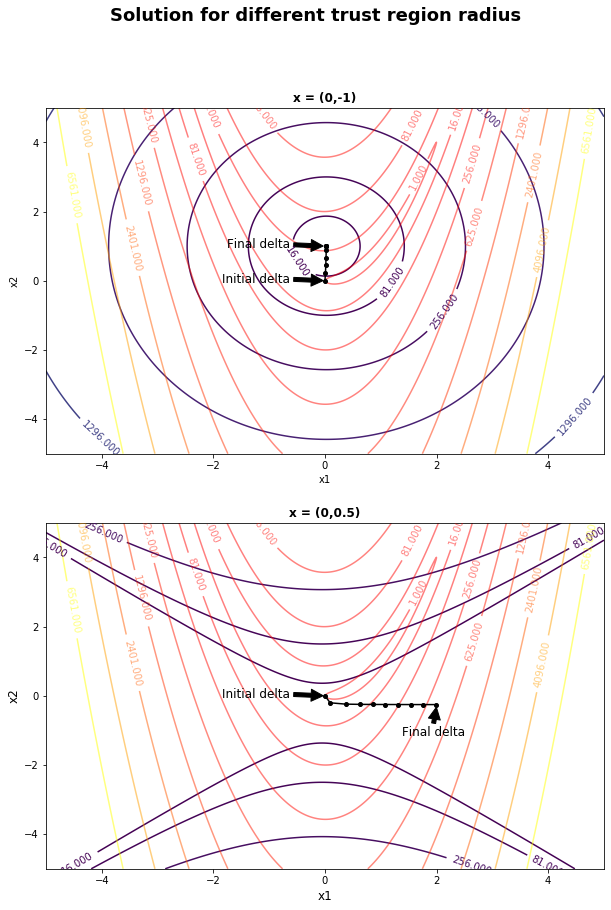

In [14]:
x = np.linspace(-5, 5, 1000)
y = np.linspace(-5, 5, 1000)
X, Y = np.meshgrid(x, y)

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figheight(14)
fig.set_figwidth(10)
fig.suptitle('Solution for different trust region radius', fontsize = 18,fontweight="bold")

xx = np.array(p1_list)
Z = 41*(X**2)+20*(Y**2) -2*X-40*Y+21
cp = ax1.contour(x,y,Z, np.arange(2,10)**4)
ax1.clabel(cp, inline=True, fontsize=10)
Z = (1-X)**2 + 20*(Y-X**2)**2
cp = ax1.contour(x,y,Z, np.arange(10)**4,cmap=cm.autumn,alpha=0.5)
ax1.clabel(cp, inline=True, fontsize=10)
ax1.plot(xx[:,0],xx[:,1], '-o', color='black', markersize=4)
ax1.set_title('x = '+str('(0,-1)'),fontsize=12,fontweight="bold")
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.annotate('Initial delta',
            xy=(0,0), xycoords='data',
            xytext=(-35, -5), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom',fontsize = 12)
ax1.annotate('Final delta',
            xy=(0,1), xycoords='data',
            xytext=(-35, -5), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom',fontsize = 12)

xx = np.array(p2_list)
Z = -19*(X**2)+20*(Y**2) -2*X+20*Y+6
cp = ax2.contour(x,y,Z, np.arange(2,10)**4)
ax2.clabel(cp, inline=True, fontsize=10)
Z = (1-X)**2 + 20*(Y-X**2)**2
cp = ax2.contour(x,y,Z, np.arange(10)**4,cmap=cm.autumn,alpha=0.5)
ax2.clabel(cp, inline=True, fontsize=10)
ax2.plot(xx[:,0],xx[:,1], '-o', color='black', markersize=4)
ax2.set_title('x = '+str('(0,0.5)'),fontsize=12,fontweight="bold")
ax2.set_xlabel('x1',fontsize=12)
ax2.set_ylabel('x2',fontsize=12)
ax2.annotate('Initial delta',
            xy=(0,0), xycoords='data',
            xytext=(-35, -5), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom',fontsize = 12)
ax2.annotate('Final delta',
            xy=(2,-0.3), xycoords='data',
            xytext=(-35, -20), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='top',fontsize = 12)
plt.show()

#### Note:
1.We observe that upon increasing delta, the quadratic model defined at $x=(0,-1)$ converges to find minimum of the model function, whereas in case of quadratic model defined at $x=(0,0.5)$, increasing trust radius beyond a certain limit overshoots the minimum of model function.<br>
2.For smaller trust region radius, the minimizer of the quadratic model is close to the minimizer of the actual function as visible from the plot in both the cases.